![Nuclio logo](https://nuclio.school/wp-content/uploads/2018/12/nucleoDS-newBlack.png)

## 1. Librerias

Para empezar carguemos esas librerias que nos hacen falta

In [52]:
from tensorflow import keras as ks
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import time
import datetime

from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model

MODELO = 7

ANCHO_IMAGEN, ALTURA_IMAGEN, CANALES_IMAGENES = 32, 32, 3

## 2. Arquitectura de red del modelo


In [26]:
model = ks.Sequential()

model.add(ks.layers.Conv2D(128, (3, 3), strides=1, activation='relu', 
          kernel_initializer='he_uniform',padding='same',input_shape=(32,32,3)))
model.add(ks.layers.Dropout(0.2))
model.add(ks.layers.Conv2D(128, (3, 3), strides=1, activation='relu', 
          kernel_initializer='he_uniform',padding='same'))
model.add(ks.layers.MaxPooling2D((2, 2)))
model.add(ks.layers.Dropout(0.6))

model.add(ks.layers.Conv2D(256, (3, 3), strides=1, activation='relu', 
          kernel_initializer='he_uniform',padding='same'))
model.add(ks.layers.Dropout(0.2))
model.add(ks.layers.Conv2D(256, (3, 3), strides=1, activation='relu', 
          kernel_initializer='he_uniform',padding='same'))
model.add(ks.layers.Dropout(0.2))
model.add(ks.layers.Conv2D(256, (3, 3), strides=1, activation='relu', 
          kernel_initializer='he_uniform',padding='same'))
model.add(ks.layers.MaxPooling2D((2, 2)))
model.add(ks.layers.Dropout(0.5))

model.add(ks.layers.Conv2D(512, (3, 3), strides=1, activation='relu', 
          kernel_initializer='he_uniform',padding='same'))
model.add(ks.layers.Dropout(0.2))
model.add(ks.layers.Conv2D(512, (3, 3), strides=1, activation='relu', 
          kernel_initializer='he_uniform',padding='same'))
model.add(ks.layers.MaxPooling2D((2, 2)))
model.add(ks.layers.Dropout(0.6))

model.add(ks.layers.Flatten())
model.add(ks.layers.Dense(512, activation='relu'))
model.add(ks.layers.Dropout(0.5))
model.add(ks.layers.Dense(512, activation='relu'))
model.add(ks.layers.Dropout(0.4))

model.add(ks.layers.Dense(10, activation='softmax'))

Para revisar un modelo, nos basta con llamar al método **.summary()** del modelo

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 128)       3584      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 256)       295168    
_________________________________________________________________
dropout_7 (Dropout)          (None, 16, 16, 256)      

## 3. Optimizador, función error


In [28]:
from tensorflow.keras.optimizers import Adam
from keras.optimizers import SGD

new_adam = Adam(learning_rate=2e-5)

#opt = SGD(lr=0.001, momentum=0.9)
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [29]:
#model.compile(optimizer='Adam',
#              loss='sparse_categorical_crossentropy',
#              metrics=['accuracy'])

## 4. Preparamos los datos

Cargamos los datos de CIFAR10 de los datasets directamente de las librerias de Keras. Estos ya estan dispuestos en train and test

**Detalle importante:** 
> La red neuronal requiere que los inputs sean números reales, y lo haremos forzando la division de los valores de dentro de las matrices 28x28 (que tienen valoress del 0 al 255) por 255.0 (un real)

In [30]:
cifar10 = ks.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0

In [31]:
y_train_label = y_train

#y_test = ks.utils.to_categorical(y_test)
#y_train = ks.utils.to_categorical(y_train)

y_test
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

Obtenemos un array con todas las labels de CIFAR10

In [32]:
cifar10_labels = [
'airplane', # id 0
'automobile',
'bird',
'cat',
'deer',
'dog',
'frog',
'horse',
'ship',
'truck',
]

print('Number of labels: %s' % len(cifar10_labels))

Number of labels: 10


Como vamos a querer ir haciendo validación a la vez que entrenamos (muy practico)

In [33]:
x_val = x_train[-10000:]
y_val = y_train[-10000:]

x_train = x_train[:-10000]
y_train = y_train[:-10000]


Cuando añadimos convoluciones, necesitamos "pre-tratar los datos", porque **la convolución es pera una matriz de 4 campos** (más parecido a "imagenes"), no un array de 3 como son actualmente los data sets de train, test y validación. Así que toca darle al **.reshape()**

Por eso, al salir de la Convolution, hay que hacer un Flatten, porque las capas FullDense esperan arrays, no matrices!!

Luego lo imprimimos para ver que todo está correcto

In [34]:
# Validamos el resultado
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))
print('Validation: X=%s, y=%s' % (x_val.shape, y_val.shape))

Train: X=(40000, 32, 32, 3), y=(40000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)
Validation: X=(10000, 32, 32, 3), y=(10000, 1)


In [35]:
#x_train_features_vgg = llevar_imagenes_cuellobotella(vgg_model, x_train)
#x_val_features_vgg = llevar_imagenes_cuellobotella(vgg_model, x_val)
#x_test_features_vgg = llevar_imagenes_cuellobotella(vgg_model, x_test)

In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    #rescale=1./255,
    #rotation_range=15,
    #zoom_range=0.1,
    #shear_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    )

train_generator = train_datagen.flow(
    x_train, 
    y_train, 
    batch_size=30
)

In [37]:
validation_datagen = ImageDataGenerator(
    #rescale=1./255
    )
validation_generator = validation_datagen.flow(
    x_val, 
    y_val, 
    batch_size=20
)

test_datagen = ImageDataGenerator(
    #rescale=1./255
    )
test_generator = test_datagen.flow(
    x_test, 
    y_test,
    batch_size=20
)

In [38]:
sample = 1100
example_generator = train_datagen.flow(
    x_train[sample:sample+1],
    y_train[sample:sample+1],
    batch_size=20
)

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


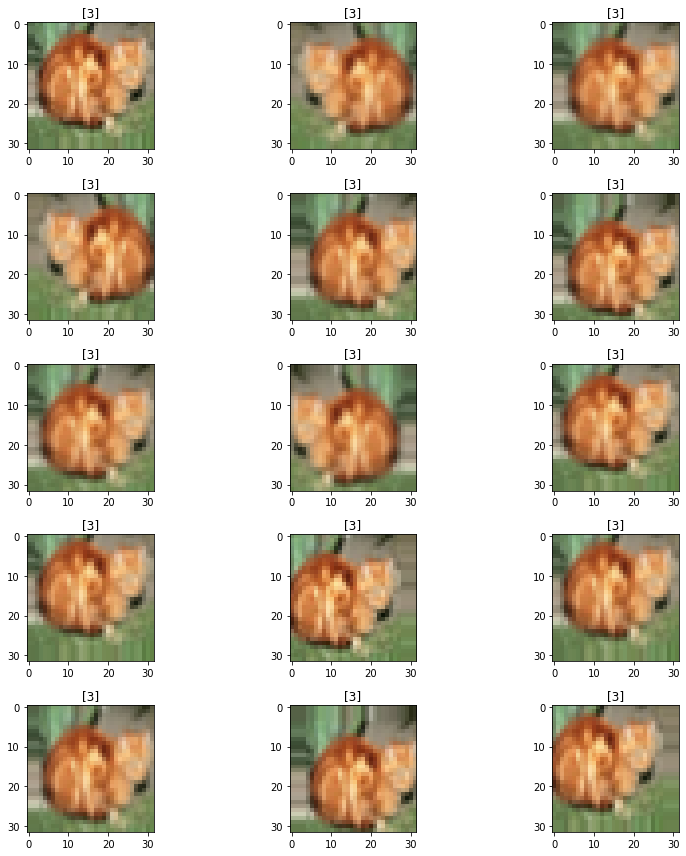

In [39]:
plt.figure(figsize=(12,12))
for i in range(0,15):
  plt.subplot(5,3,i+1)
  for X, y in example_generator:
    image = X[0]
    plt.imshow(image)
    plt.title(y[0])
    break

plt.tight_layout()
plt.show()

## 5. Entrenamiento

Ya podemos ponernos a entrenar el modelo!! Ojo, que hemos de entrenar contra los datos convertidos al formato que espera la Convolution.

Empezaremos con 30 epocs, es decir, 30 pasadas completas del dataset (que a su vez sera con mini-batches internamente), fijando un batch de 64

El metodo .fit() nos permite, definir además si disponemos de varias CPUs, GPUs, y si queremos ir validando datos a cada fin de epoch.

In [40]:
callback = EarlyStopping(monitor='val_loss', patience=10)

In [41]:
t = time.perf_counter()

In [42]:
history = model.fit(x_train, y_train, epochs=300, 
                    use_multiprocessing=False, batch_size= 512, 
                    callbacks=[callback], 
                    validation_data=(x_val, y_val))

Epoch 1/300
79/79 [==============================] - 43s 409ms/step - loss: 4.0862 - accuracy: 0.1078 - val_loss: 2.2246 - val_accuracy: 0.1771
Epoch 2/300
79/79 [==============================] - 26s 332ms/step - loss: 2.1123 - accuracy: 0.2176 - val_loss: 2.2176 - val_accuracy: 0.1657
Epoch 3/300
79/79 [==============================] - 26s 325ms/step - loss: 1.9322 - accuracy: 0.2673 - val_loss: 2.2199 - val_accuracy: 0.1861
Epoch 4/300
79/79 [==============================] - 26s 335ms/step - loss: 1.7732 - accuracy: 0.3254 - val_loss: 1.9759 - val_accuracy: 0.3153
Epoch 5/300
79/79 [==============================] - 26s 335ms/step - loss: 1.6704 - accuracy: 0.3813 - val_loss: 2.0994 - val_accuracy: 0.2928
Epoch 6/300
79/79 [==============================] - 26s 333ms/step - loss: 1.5685 - accuracy: 0.4234 - val_loss: 1.8620 - val_accuracy: 0.3541
Epoch 7/300
79/79 [==============================] - 26s 334ms/step - loss: 1.4814 - accuracy: 0.4528 - val_loss: 1.9187 - val_accuracy:

In [43]:
#history = model.fit(train_generator, steps_per_epoch = 167, 
#                            validation_steps=50, use_multiprocessing=False,
#                            epochs=300, validation_data=validation_generator)

#history = model.fit(x_train, y_train, epochs=200, 
#                    use_multiprocessing=False, batch_size= 512, 
#                    callbacks=[callback], 
#                    validation_data=(x_val, y_val))

In [44]:
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))

print('Tiempo de entrenamiento:', elapsed_time)

Tiempo de entrenamiento: 0:47:36.915351


## 6. Evaluamos los resultados

Obtengamos una grafica de como el error y la accuracy van evolucionando en cada epoch en los datos de entrenamiento y en la validación

In [45]:
_, acc = model.evaluate(x_test, y_test, verbose=0)
print('> %.3f' % (acc * 100.0))

> 84.380


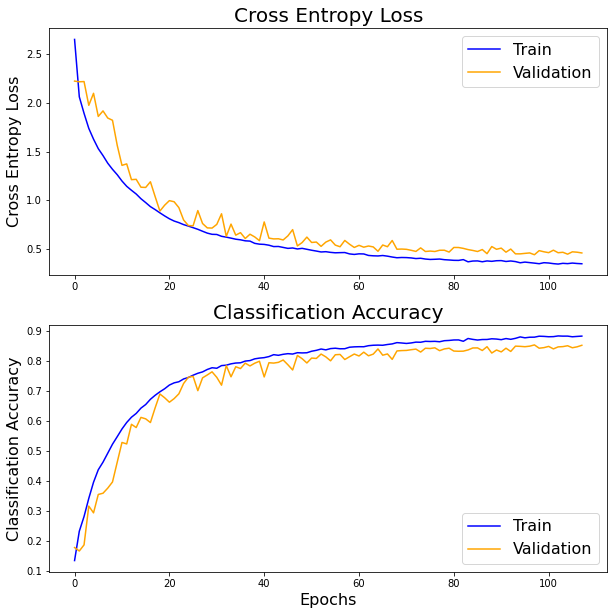

In [46]:
fig, ax = plt.subplots(2,1,figsize=(10,10))
ax[0].set_title('Cross Entropy Loss', fontsize = 20)
ax[0].plot(history.history['loss'], color='blue', label='Train')
ax[0].plot(history.history['val_loss'], color='orange', label='Validation')
ax[0].set_ylabel('Cross Entropy Loss', fontsize = 16)
ax[0].legend(fontsize = 16)

ax[1].set_title('Classification Accuracy', fontsize = 20)
ax[1].plot(history.history['accuracy'], color='blue', label='Train')
ax[1].plot(history.history['val_accuracy'], color='orange', label='Validation')
ax[1].set_ylabel('Classification Accuracy', fontsize = 16)
ax[1].set_xlabel('Epochs', fontsize = 16)
ax[1].legend(fontsize = 16)

plt.show()

In [53]:
fig.savefig("modelo_"+str(MODELO)+".png")  

El coste podemos ver que es estable y es en el epoch 15 que se fija en un valor. Además la accuracy baila alrededor de 0.10. No se puede decir que sea un modelo muy bueno.

Veamos que tipo de predicciones estoy obteniendo sobre el conjunto de test (vamos a pintar las imagenes y sus clasificaciones)

In [49]:
predictions = model.predict(x_test)

Una de las ventajas de Python es que hay montones de funciones y código realizado por terceras personas. Aquí me he fusilado unas bonitas funciones (que he adaptado un poco a mis necesidades) para poder pintar las imagenes, su label (ground truth) y las clasificaciones que hemos realizado.

In [50]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label[0]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label[0]].set_color('blue')

Dibujamos las primeras imagenes, con las predicciones y sus valores reales (un total de 20 imagenes, para no abusar de vuestros laptops)

Coloreamos las prediciones correctas en azul y los fallos en rojo. Aunque primero he impreso las etiquetas para que tengamos una referencia al grafico.

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


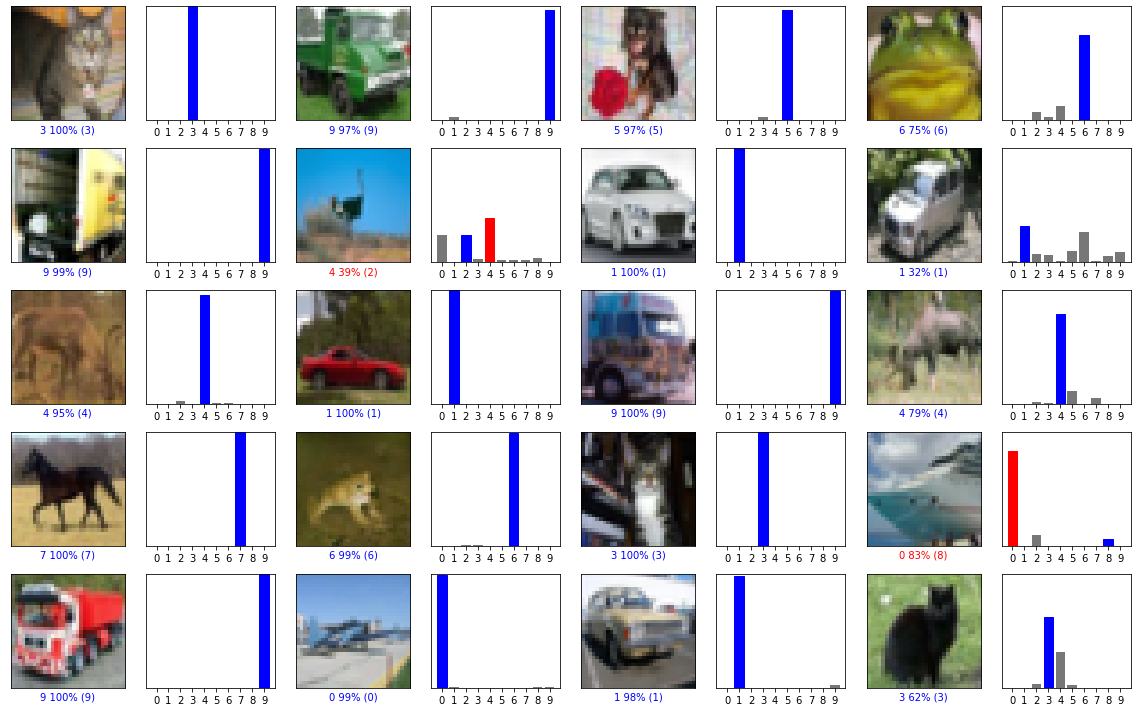

In [51]:
i = 0
for l in cifar10_labels:
    print(i, l)
    i += 1

num_rows = 5
num_cols = 4
start = 650
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i+start, predictions[i+start], y_test, x_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i+start, predictions[i+start], y_test)
plt.tight_layout()
plt.show()